In [1]:
import os
import torch
import mlflow
import gc
import time
from torch.utils.data import DataLoader

from MED.modeling.modeling_utils import train_single_epoch, validate_single_epoch, train_single_epoch_TSVN, validate_single_epoch_TSVN, \
      train_single_epoch_COG, validate_single_epoch_COG, retrieve_results_mlflow, create_summary_df, \
            define_model_objects, load_model_local, compute_window_metrics, save_model

from MED.dataset.dataset_utils import compute_window_size_stride
from MED.dataset.CustomFrameDataset import CustomFrameDataset
from MED.visualization.utils import plot_results_LOSO, plot_cm

In [4]:
#def main(): #Main loop for training.
cuda = False
if cuda:
    torch.cuda.empty_cache() # Clear cache
    
else:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    torch.mps.empty_cache()

settings = ['LOSO']#, 'LOUO']
tasks = ['All', 'Suturing','Knot_Tying','Needle_Passing']
out1 = ['Bout','Cout','Dout','Eout','Fout','Gout','Hout','Iout']
out2 = ['1out', '2Out', '3out','4out','5out']

class_counts_dict = {
    '1out': [1- 0.654465, 0.654465],
    '2Out': [1- 0.575628, 0.575628],
    '3out': [1- 0.529154, 0.529154],
    '4out': [1- 0.472940, 0.472940],
    '5out': [1- 0.430558, 0.430558]}

exp_kwargs = {
    'error_type': 'global',
    'dataset_type': 'frame', #"frame" or "window"
    'save_local': False,
    'pos_weight': False,  
    'use_COG_video': True,
    'n_epochs': 7,
    'batch_size': 1,
    'frequency': 5,
    'lr': 5e-4,
    'lr_scheduler': False, 
    'weight_decay': 0,
    'out_features': 2,
    'use_all_gestures': True, #True only if replicating completely COG results (only COG)
    'use_skill_prompt': False, #True only if concatenating skill prompt to gesture prompt (only COG)
    'SRM': False, #True if using Skill-Reasoning Module (only COG)
    'mstcn_causal_conv': True, #default True
    'mstcn_layers': 8, #8 for TeCNo, TransSVNet, COG
    'mstcn_f_maps': 64, #64 for TeCNo, TransSVNet, COG
    'mstcn_stages': 2, #2 for TeCNo, TransSVNet, 8 for COG
    'num_R': 3, #3 for COG, not used otherwise
    'num_layers_R': 10, #10 for COG, not used otherwise
    'num_layers_Basic': 11, #11 for COG, not used otherwise
    'd_model': 64, #64 for COG, not used otherwise
    'd_q': 8, #8 for COG, not used otherwise
    'lambda': 0.15, #default 0.15 for COG
    'sequence_length': 30, #default 30 in repo, but afraid of "10" I've written somewhere (same for all)
    'model_name': 'TransSVNet', #'TeCNo' or 'TransSVNet' or 'COG'
    'video_dims': 2048, #32 default
    'loss_or_f1': 'f1',  #'loss' or 'f1' to determine the metric for validation
    'data_type': 'video', #'multimodal' or 'video' or 'kinematics'
    'run_id': "3fe576bc9fd345efab6bbd8d503fd4f4", #"375e87271d994e2fbdcc248b30a332a4", #should only be defined when using TransSVNet, as we need to load a trained TeCNo and feature extractor
    'delete_ND': False, 
    'compute_from_str': False,
    'return_train_preds': False, #True if we want to return train predictions and labels
}

best_model = None
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

#Set up folders to save results and images
results_folder = f"results/{exp_kwargs['data_type']}/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/"
image_folder = f"images/{exp_kwargs['data_type']}/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/" 

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if not os.path.exists(image_folder):
    os.makedirs(image_folder)

#Define in_features
in_features_dict = {
    'multimodal': exp_kwargs['video_dims'] + 26,
    'video': exp_kwargs['video_dims'],
    'kinematics': 26
}
exp_kwargs['mstcn_f_dim'] = in_features_dict[exp_kwargs['data_type']]   

Loading data for LOSO with trial 1out...
Number of parameters to optimize: 1719552
num_stages_classification: 2, num_layers: 8, num_f_maps: 64, dim: 2048


100%|██████████| 54/54 [00:13<00:00,  4.09it/s]


Epoch 1/7, F1: 0.7501, Loss: 0.5762, Accuracy: 0.7805


Test: 100%|██████████| 13/13 [00:05<00:00,  2.28it/s]


New best F1 score: 0.6507278386916545 at epoch 1, with binary F1 score 0.6862559241706161.


Test: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


New best F1 score: 0.7032572022954817 at epoch 2, with binary F1 score 0.7706693824645866.


100%|██████████| 54/54 [00:12<00:00,  4.46it/s]


Epoch 6/7, F1: 0.9276, Loss: 0.2742, Accuracy: 0.9288


100%|██████████| 54/54 [00:12<00:00,  4.39it/s]


Epoch 7/7, F1: 0.9126, Loss: 0.3008, Accuracy: 0.9156


Test: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Inference rate: 1.9899 ms per frame.


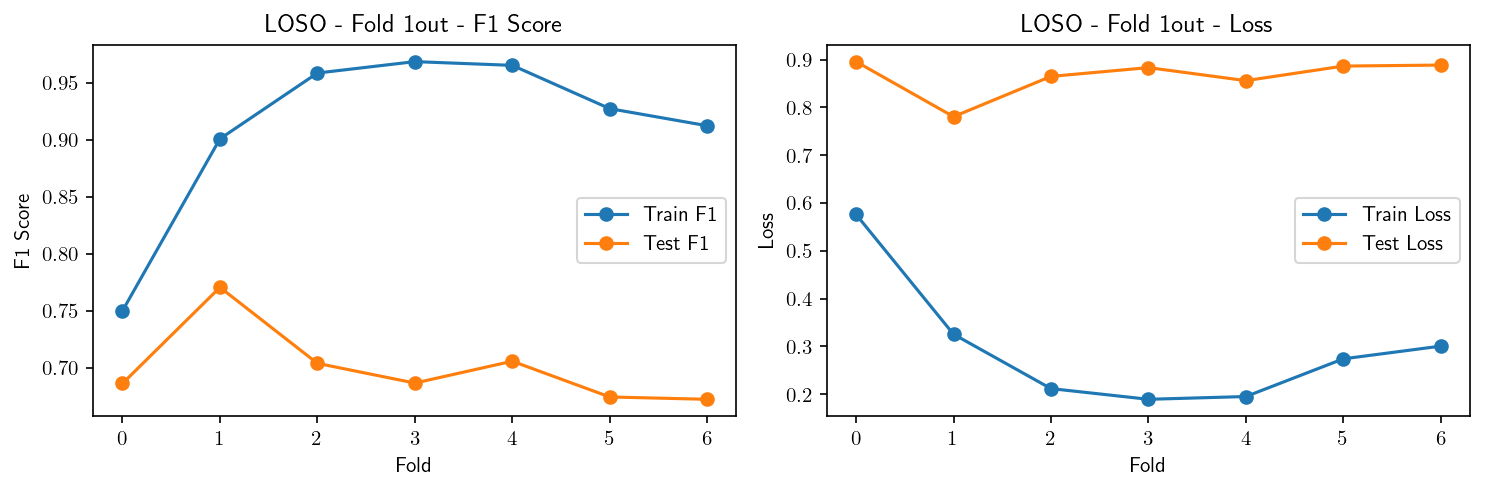

Model saved to models/video/5Hz/TransSVNet/best_model_LOSO_1out.pt
Loading data for LOSO with trial 2Out...
Number of parameters to optimize: 1719552
num_stages_classification: 2, num_layers: 8, num_f_maps: 64, dim: 2048


100%|██████████| 55/55 [00:15<00:00,  3.46it/s]


Epoch 1/7, F1: 0.6258, Loss: 1.1764, Accuracy: 0.5055


Test: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


New best F1 score: 0.520946732976283 at epoch 1, with binary F1 score 0.7077847077847078.


Test: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


New best F1 score: 0.6091892225903139 at epoch 2, with binary F1 score 0.6006779661016949.


Test: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


New best F1 score: 0.6122716160216032 at epoch 3, with binary F1 score 0.6056622851365016.


100%|██████████| 55/55 [00:12<00:00,  4.39it/s]


Epoch 6/7, F1: 0.8783, Loss: 0.4057, Accuracy: 0.8661


Test: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


New best F1 score: 0.6151947526027418 at epoch 6, with binary F1 score 0.6309486290576741.


100%|██████████| 55/55 [00:12<00:00,  4.36it/s]


Epoch 7/7, F1: 0.8719, Loss: 0.4379, Accuracy: 0.8586


Test: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Inference rate: 1.1851 ms per frame.


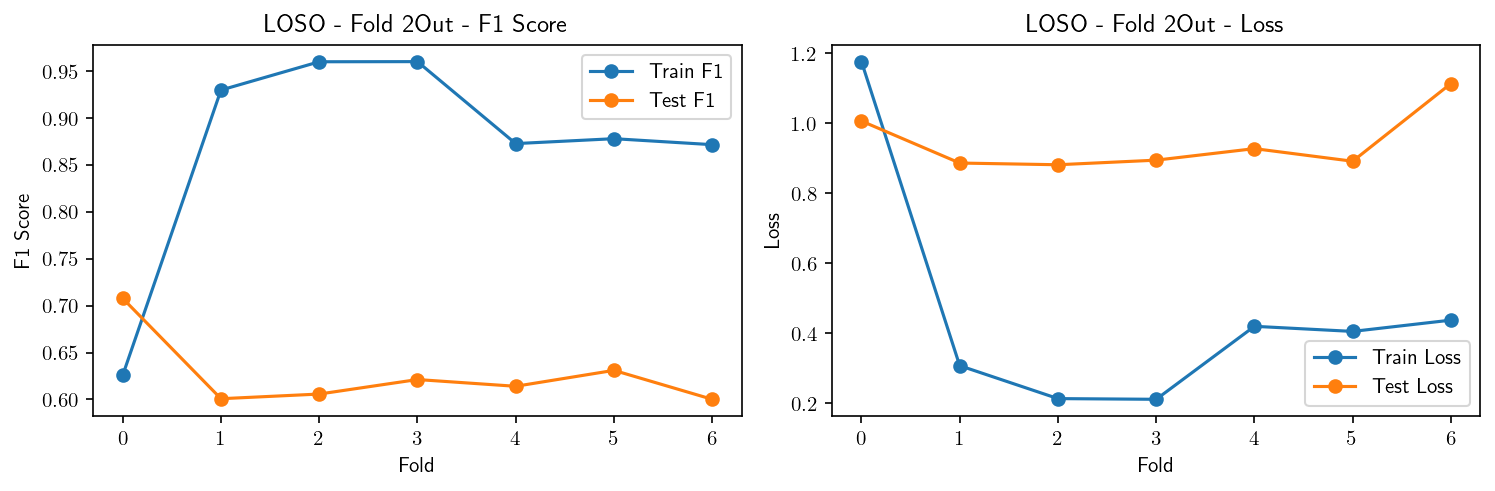

Model saved to models/video/5Hz/TransSVNet/best_model_LOSO_2Out.pt
Loading data for LOSO with trial 3out...
Number of parameters to optimize: 1719552
num_stages_classification: 2, num_layers: 8, num_f_maps: 64, dim: 2048


100%|██████████| 53/53 [00:12<00:00,  4.28it/s]


Epoch 1/7, F1: 0.8891, Loss: 0.3623, Accuracy: 0.8813


Test: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]


New best F1 score: 0.6357241921212212 at epoch 1, with binary F1 score 0.6805416248746239.


Test: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]


New best F1 score: 0.6424048123182529 at epoch 3, with binary F1 score 0.6615755627009646.


100%|██████████| 53/53 [00:12<00:00,  4.36it/s]


Epoch 6/7, F1: 0.9730, Loss: 0.1859, Accuracy: 0.9705


100%|██████████| 53/53 [00:12<00:00,  4.34it/s]


Epoch 7/7, F1: 0.9644, Loss: 0.2088, Accuracy: 0.9606


Test: 100%|██████████| 14/14 [00:04<00:00,  3.09it/s]


Inference rate: 1.4787 ms per frame.


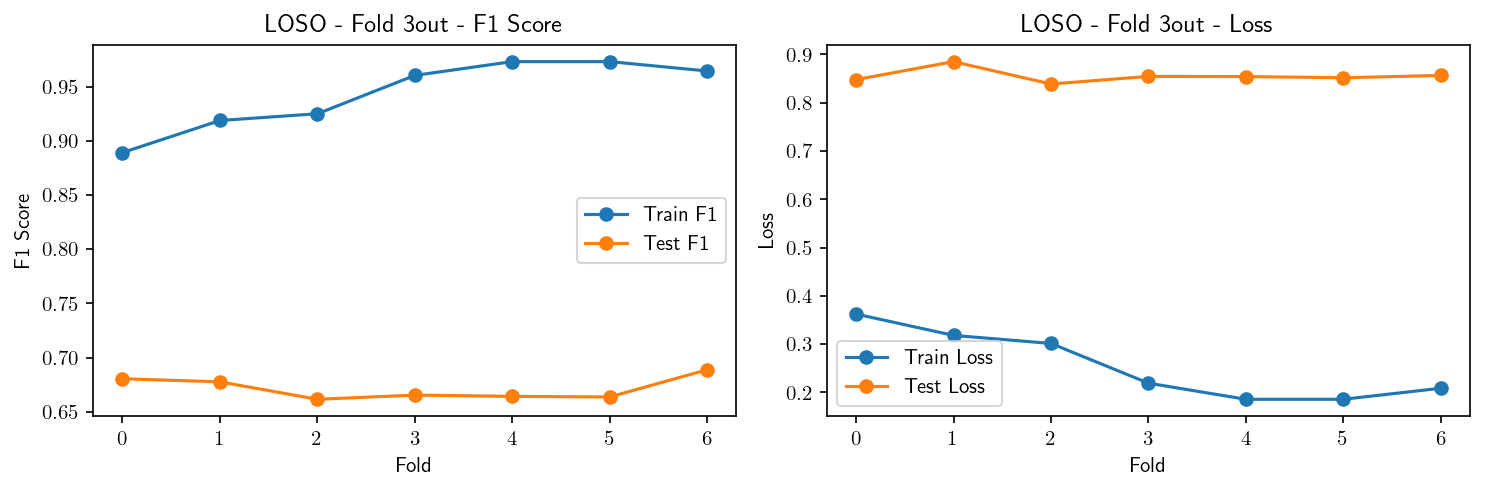

Model saved to models/video/5Hz/TransSVNet/best_model_LOSO_3out.pt
Loading data for LOSO with trial 4out...
Number of parameters to optimize: 1719552
num_stages_classification: 2, num_layers: 8, num_f_maps: 64, dim: 2048


100%|██████████| 52/52 [00:12<00:00,  4.19it/s]


Epoch 1/7, F1: 0.0220, Loss: 1.1505, Accuracy: 0.4437


Test: 100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


New best F1 score: 0.36408404654725746 at epoch 1, with binary F1 score 0.000609942055504727.


Test: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]


New best F1 score: 0.6192438579968877 at epoch 2, with binary F1 score 0.6049087099670757.


Test: 100%|██████████| 15/15 [00:04<00:00,  3.37it/s]


New best F1 score: 0.6260053813672762 at epoch 3, with binary F1 score 0.6196274020830277.


Test: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


New best F1 score: 0.6603722151760685 at epoch 4, with binary F1 score 0.6512661039537984.


100%|██████████| 52/52 [00:11<00:00,  4.37it/s]


Epoch 6/7, F1: 0.9585, Loss: 0.2215, Accuracy: 0.9546


Test: 100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


New best F1 score: 0.6676889195316856 at epoch 6, with binary F1 score 0.6171467070911235.


100%|██████████| 52/52 [00:12<00:00,  4.29it/s]


Epoch 7/7, F1: 0.9686, Loss: 0.1961, Accuracy: 0.9657


Test: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


New best F1 score: 0.6685205198780622 at epoch 7, with binary F1 score 0.6192314146668905.
Inference rate: 1.7221 ms per frame.


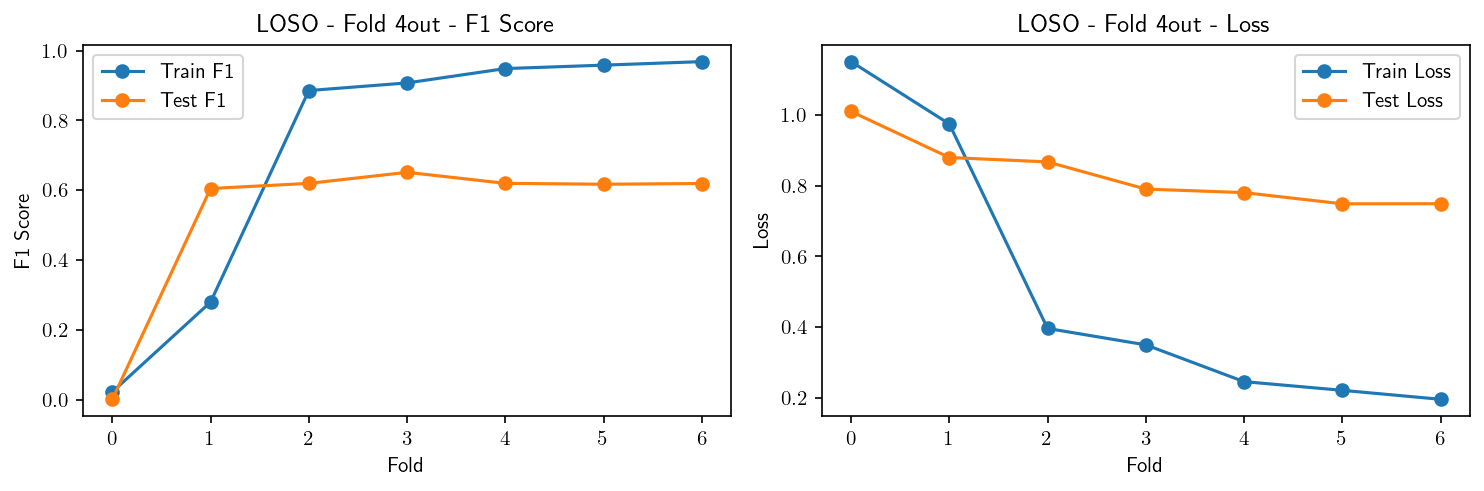

Model saved to models/video/5Hz/TransSVNet/best_model_LOSO_4out.pt
Loading data for LOSO with trial 5out...
Number of parameters to optimize: 1719552
num_stages_classification: 2, num_layers: 8, num_f_maps: 64, dim: 2048


100%|██████████| 54/54 [00:12<00:00,  4.21it/s]


Epoch 1/7, F1: 0.7908, Loss: 0.5878, Accuracy: 0.7804


Test: 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


New best F1 score: 0.6375793976245476 at epoch 1, with binary F1 score 0.5785301049925006.


Test: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


New best F1 score: 0.6461492811197148 at epoch 2, with binary F1 score 0.5958429561200924.


Test: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]


New best F1 score: 0.647482236673489 at epoch 3, with binary F1 score 0.5959957850368809.


Test: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]


New best F1 score: 0.6486321958385073 at epoch 4, with binary F1 score 0.5977688907598401.


100%|██████████| 54/54 [00:12<00:00,  4.30it/s]


Epoch 6/7, F1: 0.8657, Loss: 0.4376, Accuracy: 0.8512


100%|██████████| 54/54 [00:12<00:00,  4.29it/s]


Epoch 7/7, F1: 0.8646, Loss: 0.4387, Accuracy: 0.8509


Test: 100%|██████████| 13/13 [00:03<00:00,  3.64it/s]


Inference rate: 1.5170 ms per frame.


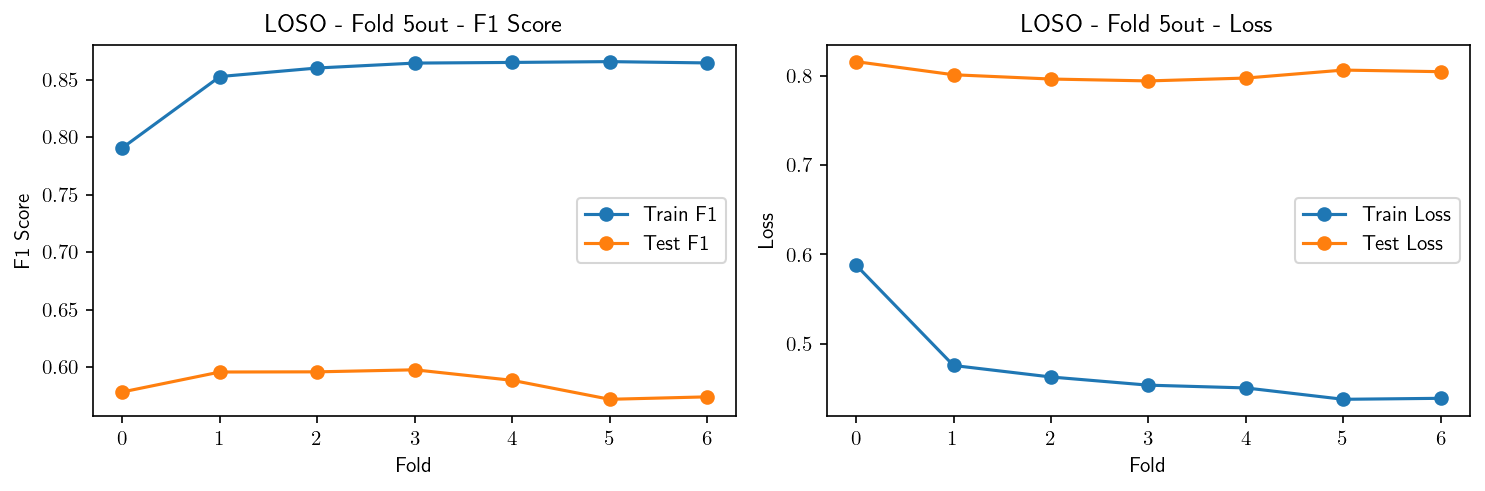

Model saved to models/video/5Hz/TransSVNet/best_model_LOSO_5out.pt
🏃 View run hilarious-owl-947 at: http://127.0.0.1:8080/#/experiments/470079469795586326/runs/4988e56c3c2d431da56d8631acb70cae
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/470079469795586326


In [5]:
mlflow.set_experiment(f"{exp_kwargs['model_name']}_{exp_kwargs['frequency']}Hz_{exp_kwargs['data_type']}")

#Ensure seed is set for reproducibility
torch.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

samples_train, samples_test, inference_rates, train_times = [], [], [], []
with mlflow.start_run() as run:
    
    #Log the hyperparameters
    if not exp_kwargs['save_local']:
        mlflow.log_params(exp_kwargs)
        run_id = run.info.run_id

    for setting in settings:

        if setting == 'LOSO':
            outs = out2
        else:
            outs = out1

        for out in outs:

            #Delete device and RAM memory
            if cuda:
                torch.cuda.empty_cache()
            else:
                torch.mps.empty_cache()
                

            test_f1_fold, test_f1_weighted_fold, test_jaccard_fold, test_acc_fold, test_precision_fold, test_recall_fold, \
            test_fpr_fold, test_tpr_fold, test_class_report_fold, test_cm_fold, train_times_fold, \
            train_f1_fold, train_f1_weighted_fold, train_acc_fold, train_jaccard_fold, train_loss_fold, test_loss_fold = \
            ([] for _ in range(17))

            best_f1 = 0.0
            best_loss = float('inf')    
            save_best = False

            #a. Load training and testing data
            print(f"Loading data for {setting} with trial {out}...")
            fold_data_path = f"data/LOSO/{exp_kwargs['frequency']}Hz/" + out + '/'
            video_data_path = f"../Chain-of-Gesture/dataset/setting_f1/LOSO/All/{out}"
            #video_data_path = None
            
            #b. Retrieve dataloaders
            train_dataset = CustomFrameDataset(fold_data_path=fold_data_path,
                                                video_data_path=video_data_path,
                                                    csv_filename='train.csv',
                                                    delete_ND=exp_kwargs['delete_ND'])
            
            test_dataset = CustomFrameDataset(fold_data_path=fold_data_path,
                                                video_data_path=video_data_path,
                                                csv_filename='test.csv',
                                                delete_ND=exp_kwargs['delete_ND'])
            
            train_dataloader = DataLoader(train_dataset, 
                                        batch_size=exp_kwargs['batch_size'], 
                                        shuffle=True,
                                        generator=torch.Generator().manual_seed(42))
            
            test_dataloader = DataLoader(test_dataset,
                                        batch_size=exp_kwargs['batch_size'], 
                                        shuffle=False,
                                        generator=torch.Generator().manual_seed(42))                                         
            
            samples_train.append(len(train_dataloader.dataset))

            #c. Define model objects
            class_counts = class_counts_dict[out]

            feature_extractor, model, criterion, optimizer, scheduler = define_model_objects(exp_kwargs=exp_kwargs,
                                                                                                in_features_dict=in_features_dict,
                                                                                                window_size=0,
                                                                                                device=device,
                                                                                                class_counts=class_counts)
            
            model_folder = f'models/{exp_kwargs["data_type"]}/{exp_kwargs["frequency"]}Hz/{model.name}/' 
            if exp_kwargs['model_name'] == 'TransSVNet':
                model_folder_Tecno = f'models/{exp_kwargs["data_type"]}/{exp_kwargs["frequency"]}Hz/TeCNo/' 
                feature_extractor, TeCNo = load_model_local(model_folder=model_folder_Tecno, 
                                                            out=out, setting=setting, 
                                                            exp_kwargs=exp_kwargs,
                                                            in_features=in_features_dict[exp_kwargs['data_type']], window_size=0, device=device)
                try:
                    feature_extractor.eval(), TeCNo.eval()    

                except:
                    TeCNo.eval()        

            #d. Training loop
            for epoch in range(exp_kwargs['n_epochs']):
                train_start = time.time()

                if exp_kwargs['model_name'] == 'TeCNo':
                    train_loss, train_f1, train_f1_weighted, train_acc, train_jaccard, train_cm, \
                        train_all_probs, train_all_preds, train_all_labels, train_all_subjects = train_single_epoch(model=model, 
                                                                feature_extractor=feature_extractor,
                                                                train_dataloader=train_dataloader,
                                                                criterion=criterion,
                                                                optimizer=optimizer,
                                                                device=device,
                                                                exp_kwargs=exp_kwargs,
                                                                scheduler=scheduler)
                
                    
                elif exp_kwargs['model_name'] == 'TransSVNet':
                    train_loss, train_f1, train_f1_weighted, train_acc, train_jaccard, train_cm = train_single_epoch_TSVN(model=model, 
                                                                TeCNo=TeCNo,
                                                                feature_extractor=feature_extractor,
                                                                train_dataloader=train_dataloader,
                                                                criterion=criterion,
                                                                optimizer=optimizer,
                                                                device=device,
                                                                exp_kwargs=exp_kwargs,
                                                                scheduler=scheduler)
                    
                elif exp_kwargs['model_name'] == 'COG':
                    
                    criterion2 = torch.nn.MSELoss()
                    if exp_kwargs['return_train_preds']:
                        train_loss, train_f1, train_f1_weighted, train_acc, \
                            train_jaccard, train_cm, train_all_probs, train_all_preds, train_all_labels, train_all_subjects = train_single_epoch_COG(model=model,
                                                                feature_extractor=feature_extractor,
                                                                train_dataloader=train_dataloader,
                                                                criterion=criterion,
                                                                criterion2=criterion2,
                                                                optimizer=optimizer,
                                                                device=device,
                                                                exp_kwargs=exp_kwargs,
                                                                scheduler=scheduler)
                
                        
                    else:
                        train_loss, train_f1, train_f1_weighted, train_acc, train_jaccard, train_cm = train_single_epoch_COG(model=model,
                                                                feature_extractor=feature_extractor,
                                                                train_dataloader=train_dataloader,
                                                                criterion=criterion,
                                                                criterion2=criterion2,
                                                                optimizer=optimizer,
                                                                device=device,
                                                                exp_kwargs=exp_kwargs,
                                                                scheduler=scheduler)
                    
                    
                train_end = time.time()
                train_times_fold.append(train_end - train_start)

                if epoch % 5 == 0 or epoch == exp_kwargs['n_epochs'] - 1:
                    print(f"Epoch {epoch + 1}/{exp_kwargs['n_epochs']}, F1: {train_f1:.4f}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

                #Append to vectors
                train_f1_fold.append(train_f1)
                train_f1_weighted_fold.append(train_f1_weighted)
                train_loss_fold.append(train_loss)
                train_acc_fold.append(train_acc)
                train_jaccard_fold.append(train_jaccard)

                #Validation loop
                if exp_kwargs['model_name'] == 'TeCNo':
                
                    test_loss, test_f1, test_f1_weighted, test_acc, test_jaccard, test_cm, inference_rate, \
                         test_all_preds, test_all_probs, test_all_labels, test_all_labels_specific, test_all_gest_labels, test_all_subjects = validate_single_epoch(model=model,
                                                            feature_extractor=feature_extractor,
                                                            test_dataloader=test_dataloader,
                                                            criterion=criterion,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs)
                    
                elif exp_kwargs['model_name'] == 'TransSVNet':
                    test_loss, test_f1, test_f1_weighted, test_acc, test_jaccard, test_cm, inference_rate, \
                        test_all_preds, test_all_probs, test_all_labels, test_all_labels_specific, test_all_gest_labels, test_all_subjects = validate_single_epoch_TSVN(model=model,
                                                            TeCNo=TeCNo,
                                                            feature_extractor=feature_extractor,
                                                            test_dataloader=test_dataloader,
                                                            criterion=criterion,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs)
                    
                elif exp_kwargs['model_name'] == 'COG':
                    criterion2 = torch.nn.MSELoss()
                    test_loss, test_f1, test_f1_weighted, test_acc, test_jaccard, test_cm, inference_rate, \
                        test_all_preds, test_all_probs, test_all_labels, test_all_labels_specific, test_all_gest_labels, test_all_subjects = validate_single_epoch_COG(model=model,
                                                            feature_extractor=feature_extractor,
                                                            test_dataloader=test_dataloader,
                                                            criterion=criterion,
                                                            criterion2=criterion2,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs)

                #Append to vectors
                test_f1_fold.append(test_f1)
                test_f1_weighted_fold.append(test_f1_weighted)
                test_acc_fold.append(test_acc)
                test_jaccard_fold.append(test_jaccard)
                test_loss_fold.append(test_loss)
                

                if exp_kwargs['loss_or_f1'] == 'loss':
                    if test_loss < best_loss:
                        save_best = True
                        best_loss = test_loss
                        print(f"New best loss: {test_loss} at epoch {epoch + 1}")

                elif exp_kwargs['loss_or_f1'] == 'f1':
                    if test_f1_weighted > best_f1:
                        save_best = True
                        best_f1 = test_f1_weighted
                        print(f"New best F1 score: {test_f1_weighted} at epoch {epoch + 1}, with binary F1 score {test_f1}.")

                if save_best:
                    
                    if not exp_kwargs['return_train_preds']:
                        best_model = {
                            'feature_extractor': feature_extractor,
                            'model': model,
                            'epoch': epoch + 1,
                            'train_f1_fold': train_f1,
                            'test_f1_fold': test_f1,
                            'train_acc_fold': train_acc,
                            'test_acc_fold': test_acc,
                            'train_jaccard_fold': train_jaccard,
                            'test_jaccard_fold': test_jaccard,
                            'train_cm_fold': train_cm.tolist(),
                            'test_cm_fold': test_cm.tolist(),  
                            'test_all_preds_fold': test_all_preds,
                            'test_all_probs_fold': test_all_probs,
                            'test_all_labels_fold': test_all_labels,
                            'test_all_labels_specific_fold': test_all_labels_specific,
                            'test_all_gest_labels_fold': test_all_gest_labels,
                            'test_all_subjects_fold': test_all_subjects,
                        }
                    else:
                        best_model = {
                            'feature_extractor': feature_extractor,
                            'model': model,
                            'epoch': epoch + 1,
                            'train_f1_fold': train_f1,
                            'test_f1_fold': test_f1,
                            'train_acc_fold': train_acc,
                            'test_acc_fold': test_acc,
                            'train_jaccard_fold': train_jaccard,
                            'test_jaccard_fold': test_jaccard,
                            'train_cm_fold': train_cm.tolist(),
                            'test_cm_fold': test_cm.tolist(),  
                            'test_all_preds_fold': test_all_preds,
                            'test_all_probs_fold': test_all_probs,
                            'test_all_labels_fold': test_all_labels,
                            'test_all_labels_specific_fold': test_all_labels_specific,
                            'test_all_gest_labels_fold': test_all_gest_labels,
                            'test_all_subjects_fold': test_all_subjects,
                            'train_all_probs_fold': train_all_probs,
                            'train_all_preds_fold': train_all_preds,
                            'train_all_labels_fold': train_all_labels,
                            "train_all_subjects_fold": train_all_subjects
                        }

                    save_best = False  #Reset save_best to False after saving the best model
                
                if not exp_kwargs['save_local']:
                    #Log metrics to mlflow
                    mlflow.log_metric(f'train_loss_fold_{out}', train_loss, step=epoch)
                    mlflow.log_metric(f'test_loss_fold_{out}', test_loss, step=epoch)
                    mlflow.log_metric(f'train_f1_fold_{out}', train_f1, step=epoch)
                    mlflow.log_metric(f'test_f1_fold_{out}', test_f1, step=epoch)
                    mlflow.log_metric(f'train_acc_fold_{out}', train_acc, step=epoch)
                    mlflow.log_metric(f'test_acc_fold_{out}', test_acc, step=epoch)
                    mlflow.log_metric(f'train_jaccard_fold_{out}', train_jaccard, step=epoch)
                    mlflow.log_metric(f'test_jaccard_fold_{out}', test_jaccard, step=epoch)
                    
            #Display results for fold
            print(f"Inference rate: {inference_rate:.4f} ms per frame.")
            plot_results_LOSO(train_f1_fold=train_f1_fold,
                            test_f1_fold=test_f1_fold,
                            train_loss_fold=train_loss_fold,
                            test_loss_fold=test_loss_fold,
                            setting=setting, out=out,
                            image_folder=image_folder)
            
        
            #Save best model
            if exp_kwargs['save_local']:
                pass   
                        
            else:
                #Log model to mlflow
                #if exp_kwargs['data_type'] != 'kinematics':
                    
                    #mlflow.pytorch.log_model(pytorch_model=best_model['feature_extractor'], 
                        #                    name=f'feature_extractor_{setting}_{out}')
                                
                #mlflow.pytorch.log_model(pytorch_model=best_model['model'], 
                      #                  name=f'model_{setting}_{out}')        
                      # 

                #Save model locally because mlflow gives errors
                if exp_kwargs['data_type'] != 'kinematics' and exp_kwargs['video_dims'] != 2048:
                    best_model['feature_extractor'] = best_model['feature_extractor'].state_dict()
                    best_model['model'] = best_model['model'].state_dict()

                else:
                    best_model['feature_extractor'] = None
                    best_model['model'] = best_model['model'].state_dict()
                
                if not os.path.exists(model_folder):    
                    os.makedirs(model_folder)

                model_path = os.path.join(model_folder, f'best_model_{setting}_{out}.pt')   
                save_model(best_model=best_model, model_path=model_path)    

                #Log best_model rest of the dictionary without the state dicts
                best_model_dict = best_model.copy()
                best_model_dict.pop('feature_extractor', None)
                best_model_dict.pop('model', None)
                mlflow.log_dict(best_model_dict, f'best_model_{setting}_{out}.json')

            #Compute mean inference rate and train time; append to lists
            samples_test.append(len(test_all_preds))
            inference_rates.append(inference_rate)
            train_times.append(sum(train_times_fold) / len(train_times_fold))

            #Delete memory and variables
            del train_dataloader, test_dataloader, feature_extractor, model, best_model
            gc.collect()

mlflow.end_run()

,F1,Accuracy,Jaccard,Train Time,Inference Rate
Train,0.907 ± 0.037,0.898 ± 0.042,0.832 ± 0.063,12.59 ± 0.31,NaN
Test,0.664 ± 0.064,0.659 ± 0.031,0.501 ± 0.075,NaN,1.58 ± 0.27


Confusion Matrix for Train:
Confusion Matrix for Train:


<Figure size 2250x2250 with 0 Axes>

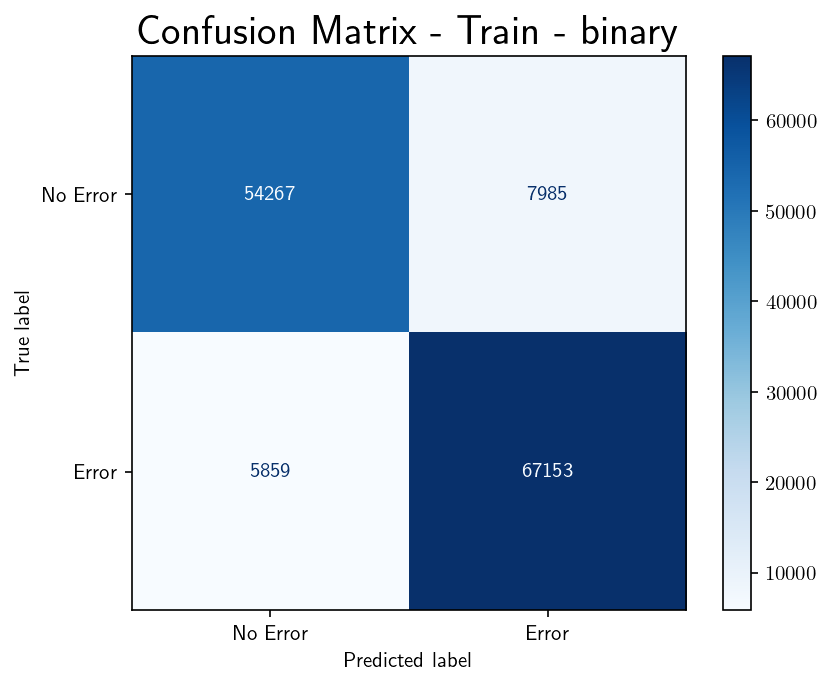

Confusion Matrix for Test:


<Figure size 2250x2250 with 0 Axes>

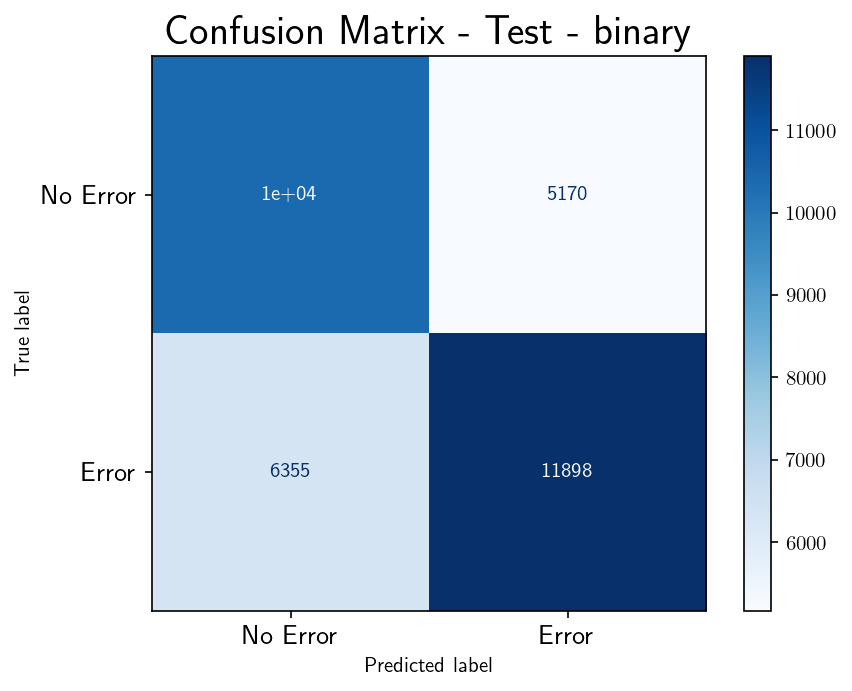

In [6]:
if exp_kwargs['return_train_preds']:
    LOSO_f1_train, LOSO_f1_test, LOSO_acc_train, LOSO_acc_test,\
    LOSO_jaccard_train, LOSO_jaccard_test, LOSO_cm_train, LOSO_cm_test, \
    train_all_preds, train_all_probs, train_all_labels, train_all_subjects, \
    test_all_preds, test_all_probs, test_all_labels, test_all_labels_specific, test_all_gest_labels, test_all_subjects = retrieve_results_mlflow(outs=outs,
                                                                                    exp_kwargs=exp_kwargs,
                                                                                    setting=setting,
                                                                                    run_id=run_id)
else:
    LOSO_f1_train, LOSO_f1_test, LOSO_acc_train, LOSO_acc_test, LOSO_jaccard_train, LOSO_jaccard_test, LOSO_cm_train, LOSO_cm_test, \
    test_all_preds, test_all_probs, test_all_labels, test_all_labels_specific, test_all_gest_labels, test_all_subjects = retrieve_results_mlflow(outs=outs,
                                                                                    exp_kwargs=exp_kwargs,
                                                                                    setting=setting,
                                                                                    run_id=run_id)


summary_df = create_summary_df(LOSO_f1_train=LOSO_f1_train, LOSO_f1_test=LOSO_f1_test, LOSO_acc_train=LOSO_acc_train,
                                LOSO_acc_test=LOSO_acc_test, LOSO_jaccard_train=LOSO_jaccard_train, LOSO_jaccard_test=LOSO_jaccard_test,
                                samples_train=samples_train, samples_test=samples_test,inference_rates=inference_rates, train_times=train_times)

#Save summary df to csv
display(summary_df)
#summary_df.to_csv(os.path.join(results_folder, 'LOSO_summary_df.csv'), index=False)
    
print("Confusion Matrix for Train:")
plot_cm(LOSO_cm_train = LOSO_cm_train, LOSO_cm_test= LOSO_cm_test, image_folder=image_folder, binary="binary")

,F1,Accuracy,Jaccard
Windowed Metrics,0.686 ± 0.072,0.661 ± 0.042,0.527 ± 0.088


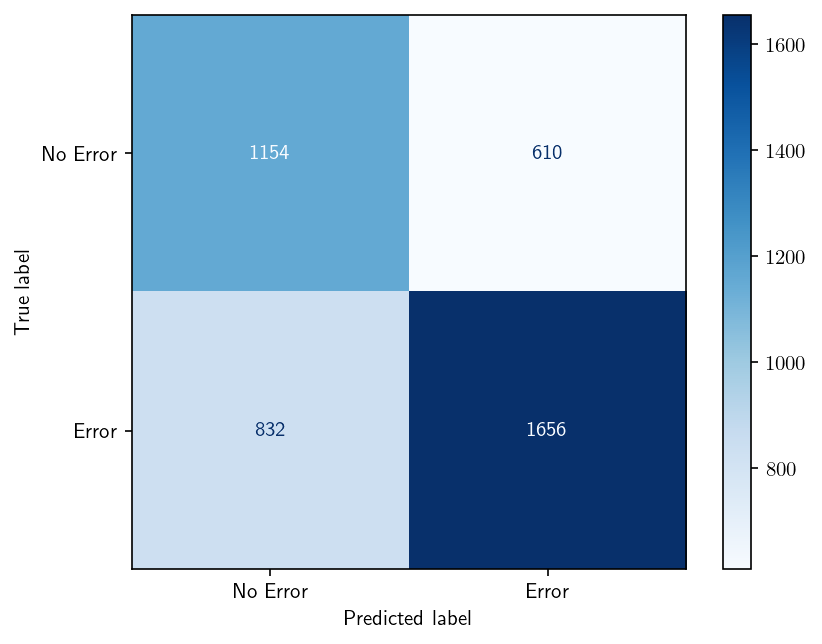

In [7]:
window_size, stride = compute_window_size_stride(frequency=exp_kwargs['frequency'])
summary_df_window, cm_window_test = compute_window_metrics(outs= outs,
                                                           test_all_preds= test_all_preds,
                                                            test_all_labels= test_all_labels_specific,
                                                            test_all_gest_labels= test_all_gest_labels,
                                                            test_all_subjects= test_all_subjects,
                                                            window_size=window_size,
                                                            stride=stride)


#Save summary df to csv
display(summary_df_window)
#summary_df_window.to_csv(os.path.join(results_folder, 'LOSO_summary_df_window.csv'), index=False)

#Plot CM test
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm_window_test, display_labels=['No Error', 'Error']).plot(cmap='Blues')